Loading light curves: 100%|████████████████| 6000/6000 [00:30<00:00, 197.70it/s]


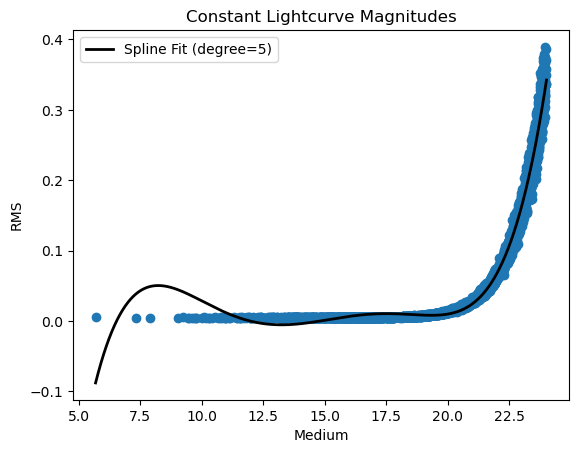

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from MicroLIA import noise_models
from tqdm import tqdm

# Generate a noise model using only the constant lightcurves Karen shared
path = 'Data_TV_Classifier/Data/trilegal2_i/'
path = 'Data_TV_Classifier/microlia_models/ELASTICC2_i_Valid_Chi_Constant/Constant/'
fnames = [i for i in os.listdir(path) if '.txt' in i]

# Save the median mag and the corresponding rms for every lightcurve
rms_mag, median_mag = [], []
for name in tqdm(fnames, desc = "Loading light curves"):
	mag = np.loadtxt(path+name)[:,1]
	rms = 0.5*np.abs(np.percentile(mag,84) - np.percentile(mag,16))
	rms_mag.append(rms); median_mag.append(np.median(mag))

# Create the noise model using the noise_models module -- this is a fifth degree 1D spline fit
elastic_noise = noise_models.create_noise(median_mag, rms_mag, degree=5)

# To visualize the scatter and noise model fit
mags = np.linspace(np.min(median_mag), np.max(median_mag), 1000)
plt.scatter(median_mag, rms_mag)
plt.plot(mags, elastic_noise(mags), linewidth=2, color='k', label='Spline Fit (degree=5)')
plt.xlabel('Medium'); plt.ylabel('RMS'); plt.title('Constant Lightcurve Magnitudes')
plt.legend()
plt.show()

In [20]:
### Simulate the training set using the noise model as generated above ###

from MicroLIA import training_set

# Loop through the lightcurves of all compiled classes, which are the folder names
path = 'Data_TV_Classifier/microlia_models/ELASTICC2_i_Valid_Chi_Constant/'
categories = ['Cepheid/', 'd-Sct/', 'uLens-Single_PyLIMA/', 'EB/', 'RRL/', 'uLens-Binary/', 'uLens-Single-GenLens/', 'Constant/'] #'dwarf-nova', 'Mdwarf-flare'

# Save the timestamps of each lightcurve as well as the corresponding median magnitude 
timestamps, median_mag = [], []
for category in categories:
	lc_file_names = [fname for fname in os.listdir(path+category) if '.dat' in fname]
	for name in tqdm(lc_file_names, desc=category): 
		if name.startswith("._"):
			name = name[2:]
		data = np.loadtxt(path+category+name)
		timestamps.append(data[:,0]); median_mag.append(np.median(data[:,1]))

Cepheid/


Cepheid/: 100%|███████████████████████████| 32724/32724 [05:37<00:00, 96.98it/s]


d-Sct/


d-Sct/: 100%|█████████████████████████████| 57700/57700 [11:29<00:00, 83.73it/s]


uLens-Single_PyLIMA/


uLens-Single_PyLIMA/: 100%|███████████████| 7608/7608 [00:01<00:00, 5338.89it/s]


EB/


EB/: 100%|████████████████████████████████| 78830/78830 [16:36<00:00, 79.12it/s]


RRL/


RRL/: 100%|███████████████████████████████| 38902/38902 [09:55<00:00, 65.29it/s]


uLens-Binary/


uLens-Binary/: 100%|██████████████████████| 3982/3982 [00:00<00:00, 5285.83it/s]


uLens-Single-GenLens/


uLens-Single-GenLens/: 100%|████████████████| 7478/7478 [01:43<00:00, 72.57it/s]


Constant/


Constant/: 100%|██████████████████████████| 12564/12564 [02:55<00:00, 71.76it/s]


RuntimeError: Unable to simulate proper CV in 100 tries with current cadence -- inspect cadence and try again.

In [21]:
zeropoint_i = 27.85 # Instrumental zeropoint for LSST (https://smtn-002.lsst.io)
exptime = 30 # LSST typical exposure time (https://smtn-002.lsst.io)
apply_weights = True # Will consider the magnitude errors when calculating the lightcurve statistics 
n_class = 1000 # Will simulate 1000 per class
cv_n1 = 5 # Minimum number of points during the rise each CV lightcurve must have
cv_n2 = 1 # Minimum number of points during the drop each CV lightcurve must have
save_file = True # Whether to save the training set, as by default it only returns it (note that this will always save to the local home directory)
filename = 'Simulated_Training_Set_1000' # Pandas dataframe will be saved with the following name: 'MicroLIA_Training_Set_'+filename+'.csv'

# Generate and save the training set
data_x, data_y = training_set.create(timestamps, min_mag=np.min(median_mag), max_mag=np.max(median_mag), noise=elastic_noise, 
	zp=zeropoint_i, exptime=exptime, n_class=n_class, apply_weights=apply_weights, save_file=save_file, filename=filename, cv_n1=cv_n1, cv_n2=cv_n2)

RuntimeError: Unable to simulate proper CV in 100 tries with current cadence -- inspect cadence and try again.

In [ ]:
### t-SNE projections to compare the simulations with the elastic lightcurves ###

import pandas as pd
from MicroLIA import ensemble_model

# Load the simulated training set csv as saved above
simulated_training_set = pd.read_csv('/Users/daniel/MicroLIA_Training_Set_Simulated_Training_Set_1000.csv')

# Load the original training set csv file I shared (inside the microlia_models directory) 
elastic_training_set = pd.read_csv('/Users/daniel/Desktop/Folders/microlia_models/MicroLIA_Training_Set_Filtered_Training_Set_1000.csv')

# First we'll look at only the binary elasticc classes
binary_classes = ['Cepheid', 'EB', 'RRL', 'd-Sct']
elastic_binaries = elastic_training_set[elastic_training_set['label'].isin(binary_classes)]
elastic_binaries['label'] = 'ELAsTiCC Variables' # To make these all a single class

# These are the variable lightcurves MicroLIA can simulate
binary_classes = ['LPV', 'VARIABLE', 'CV']
simulated_binaries = simulated_training_set[simulated_training_set['label'].isin(binary_classes)]
simulated_binaries['label'] = 'Simulated-' + simulated_binaries['label'] # To

# Combine into a single training set
binaries = pd.concat([elastic_binaries, simulated_binaries])

# Load the Classifier to use the built-in tSNE projection method
model = ensemble_model.Classifier(training_data=binaries)
model.load('/Users/daniel/Desktop/Folders/microlia_models/Filtered_Training_Set_1000_xgb_Model')
model.plot_tsne(title='Variables Parameter Space')

# Next we'll compare the microlensing classes
ml_classes = ['uLens-Binary', 'uLens-Single-GenLens', 'uLens-Single_PyLIMA']
elastic_ml = elastic_training_set[elastic_training_set['label'].isin(ml_classes)]

ml_classes = ['ML', 'CV']
simulated_ml = simulated_training_set[simulated_training_set['label'].isin(ml_classes)]
simulated_ml['label'] = 'Simulated-' + simulated_ml['label']

microlensing = pd.concat([elastic_ml, simulated_ml])

# Re-load the Classifier with this new training_data
model = ensemble_model.Classifier(training_data=microlensing)
model.load('/Users/daniel/Desktop/Folders/microlia_models/Filtered_Training_Set_1000_xgb_Model')
model.plot_tsne(title='Microlensing Parameter Space')

# Finally we will compare the constant classes
constant = ['Constant']
elastic_constant = elastic_training_set[elastic_training_set['label'].isin(constant)]
elastic_constant['label'] = 'ELAsTiCC-' + elastic_constant['label']

constant = ['CONSTANT']
simulated_constant = simulated_training_set[simulated_training_set['label'].isin(constant)]
simulated_constant['label'] = 'Simulated-' + simulated_constant['label']

constant = pd.concat([elastic_constant, simulated_constant])

# Re-load the Classifier with this new training_data
model = ensemble_model.Classifier(training_data=constant)
model.load('/Users/daniel/Desktop/Folders/microlia_models/Filtered_Training_Set_1000_xgb_Model')
model.plot_tsne(title='Constant Parameter Space')

In [ ]:
### Dreep-feed analysis ###

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MicroLIA import ensemble_model 

# For this analysis we'll use the original XGB model I shared trained with only five classess
training_set = pd.read_csv('/Users/daniel/Desktop/Folders/microlia_models/MicroLIA_Training_Set_Filtered_Training_Set_1000.csv')
classes_to_use = ['Constant', 'd-Sct', 'EB', 'RRL', 'uLens-Single_PyLIMA']
training_set = training_set[training_set['label'].isin(classes_to_use)]

model = ensemble_model.Classifier(clf='xgb', impute=True, training_data=training_set)
model.load('/Users/daniel/Desktop/Folders/microlia_models/Filtered_Training_Set_1000_xgb_Model')

# Now we can make the predictions #

zeropoint_i = 27.85 # Instrumental zeropoint for LSST (https://smtn-002.lsst.io)
convert = True # To convert from apparent magnitudes to flux
apply_weights = True # Will consider the magnitude errors when calculating the lightcurve statistics 

# Single lens example -- will save the first 1000 images

path = '/Users/daniel/Desktop/Folders/microlia_models/ELASTICC2_i_Valid_Chi_Constant/uLens-Single_PyLIMA/'
filenames = [fname for fname in os.listdir(path) if '.dat' in fname]

counter = 1
for filename in filenames:
	print(f"{counter} out of 1000")
	# Load the lightcurve
	data = np.loadtxt(path+filename)
	time, mag, magerr = data[:,0], data[:,1], data[:,2]
	#
	# To save these predictions one timestamp at a time
	constant_preds, eb_preds, rrl_preds, dsct_preds, uLens_single_preds = [], [], [], [], []
	#
	# Loop through the lightcurve starting with at least 3 points
	for i in range(3, len(data)+1):
		# Make the prediction using only up to i number of points
		prediction = model.predict(time[:i], mag[:i], magerr[:i], convert=convert, apply_weights=apply_weights, zp=zeropoint_i)	
		#
		# Save the probability predictions of each class
		constant_preds.append(prediction[:,1][0])
		eb_preds.append(prediction[:,1][1])
		rrl_preds.append(prediction[:,1][2])
		dsct_preds.append(prediction[:,1][3])
		uLens_single_preds.append(prediction[:,1][4])
	#
	### Plot the drip-feeding analysis ###
	#
	fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
	fig.suptitle(f'uLens-Single_PyLIMA Dripfeed: {filename}', y=0.92)
	# Top subplot: Light curve
	ax1.errorbar(time, mag, yerr=magerr, fmt='o', color='black', markersize=3)
	ax1.invert_yaxis()  
	# Bottom subplot: Probability predictions
	ax2.plot(time[2:], constant_preds, label='Constant', color='blue')
	ax2.plot(time[2:], eb_preds, label='EB', color='orange')
	ax2.plot(time[2:], rrl_preds, label='RRL', color='green')
	ax2.plot(time[2:], dsct_preds, label='d-Sct', color='red')
	ax2.plot(time[2:], uLens_single_preds, label='uLens Single', color='purple')
	# Add a red scatter point to denote the first time uLens_single_preds is above all others
	first_index = np.argmax(uLens_single_preds > np.max([constant_preds, eb_preds, rrl_preds, dsct_preds], axis=0))
	ax1.scatter(time[first_index+2], mag[first_index+2], color='red', s=40, label='First Detection')
	ax2.scatter(time[2:][first_index], uLens_single_preds[first_index], color='red', s=40)
	ax1.set_ylabel('Magnitude'); ax2.set_xlabel('Time'); ax2.set_ylabel('Probability')
	ax1.legend(); ax2.legend(ncol=2, handlelength=0.5)
	# Save the figure
	plt.savefig(f'/Users/daniel/Desktop/uLens_Single_Dripfeed_{filename[:-4]}.png', dpi=300, bbox_inches='tight'); plt.clf() 
	if counter == 1000: break 
	counter += 1

### Binary lens example ###

path = '/Users/daniel/Desktop/Folders/microlia_models/ELASTICC2_i_Valid_Chi_Constant/uLens-Binary/'
filenames = [fname for fname in os.listdir(path) if '.dat' in fname]

counter = 1
for filename in filenames:
	print(f"{counter} out of 500")
	# Load the lightcurve
	data = np.loadtxt(path+filename)
	time, mag, magerr = data[:,0], data[:,1], data[:,2]
	#
	# To save these predictions one timestamp at a time
	constant_preds, eb_preds, rrl_preds, dsct_preds, uLens_single_preds = [], [], [], [], []
	#
	# Loop through the lightcurve starting with at least 3 points
	for i in range(3, len(data)+1):
		# Make the prediction using only up to i number of points
		prediction = model.predict(time[:i], mag[:i], magerr[:i], convert=convert, apply_weights=apply_weights, zp=zeropoint_i)	
		#
		# Save the probability predictions of each class
		constant_preds.append(prediction[:,1][0])
		eb_preds.append(prediction[:,1][1])
		rrl_preds.append(prediction[:,1][2])
		dsct_preds.append(prediction[:,1][3])
		uLens_single_preds.append(prediction[:,1][4])
	#
	### Plot the drip-feeding analysis ###
	#
	fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
	fig.suptitle(f'uLens-Binary_PyLIMA Dripfeed: {filename}', y=0.92)
	# Top subplot: Light curve
	ax1.errorbar(time, mag, yerr=magerr, fmt='o', color='black', markersize=3)
	ax1.invert_yaxis()  
	# Bottom subplot: Probability predictions
	ax2.plot(time[2:], constant_preds, label='Constant', color='blue')
	ax2.plot(time[2:], eb_preds, label='EB', color='orange')
	ax2.plot(time[2:], rrl_preds, label='RRL', color='green')
	ax2.plot(time[2:], dsct_preds, label='d-Sct', color='red')
	ax2.plot(time[2:], uLens_single_preds, label='uLens Single', color='purple')
	# Add a red scatter point to denote the first time uLens_single_preds is above all others
	first_index = np.argmax(uLens_single_preds > np.max([constant_preds, eb_preds, rrl_preds, dsct_preds], axis=0))
	ax1.scatter(time[first_index+2], mag[first_index+2], color='red', s=40, label='First Detection')
	ax2.scatter(time[2:][first_index], uLens_single_preds[first_index], color='red', s=40)
	ax1.set_ylabel('Magnitude'); ax2.set_xlabel('Time'); ax2.set_ylabel('Probability')
	ax1.legend(); ax2.legend(ncol=2, handlelength=0.5)
	# Save the figure
	plt.savefig(f'/Users/daniel/Desktop/uLens_Binary_Dripfeed_{filename[:-4]}.png', dpi=300, bbox_inches='tight'); plt.clf() 
	if counter == 500: break 
	counter += 1